In [1]:
import pandas as pd
import torch
from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)

/home/zuber_purahoo2/datascience-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PHASE 1 - DATASET LOADING

A 30K sample in the format of (query,positive passage,negative passage) is retrieved from the original dataset 'triples.train.small.tsv'

In [2]:
####### DO NOT USE THIS DATASET ########
####### USE: qidpidtriples.top3.clean.tsv ########
file_path = r"qidpidtriples.top3.clean.tsv"

df = pd.read_csv(
    file_path,
    sep='\t',
    header=None,
    names=["qid", "query", "pos_pid", "positive", "neg_pid", "negative"],
    encoding='utf-16',
)
print(df.shape)
df.head()

(42274, 6)


,qid,query,pos_pid,positive,neg_pid,negative
0,1000094,where is whitemarsh island,5399011,"Whitemarsh Island, Georgia. Whitemarsh Island ...",4239068,Pea Island is an island which is part of the O...
1,1000094,where is whitemarsh island,5399011,"Whitemarsh Island, Georgia. Whitemarsh Island ...",271630,Underwater Volcano Forms New South Pacific Isl...
2,1000094,where is whitemarsh island,5399011,"Whitemarsh Island, Georgia. Whitemarsh Island ...",5534953,"Komodo is one of the 17,508 islands that make ..."
3,1000684,where is your perineum,6133670,That part of the floor of the PELVIS that lies...,54955,rule of nines (rÅ«l nÄ«nz) Method used in calc...
4,1000684,where is your perineum,6133670,That part of the floor of the PELVIS that lies...,5952792,This delicate triangle is important during chi...


In [3]:

# Convert to Hugging Face Dataset
from datasets import Dataset
df = df.dropna(subset=['positive','negative'])
train_dataset = Dataset.from_pandas(df)

print(train_dataset[0])


{'qid': 1000094, 'query': 'where is whitemarsh island', 'pos_pid': 5399011, 'positive': 'Whitemarsh Island, Georgia. Whitemarsh Island (pronounced WIT-marsh) is a census-designated place (CDP) in Chatham County, Georgia, United States. The population was 6,792 at the 2010 census. It is part of the Savannah Metropolitan Statistical Area. The communities of Whitemarsh Island are a relatively affluent suburb of Savannah.', 'neg_pid': 4239068, 'negative': 'Pea Island is an island which is part of the Outer Banks of North Carolina. Because of the shifting nature of the barrier island system of which Pea Island is a part, and the way in which inlets open and close over time, Pea Island has, at times, been contiguous with the neighboring islands of Bodie Island or Hatteras Island.'}


PHASE 2: TRAINING STAGE

1. The first step is to load the question and context encoders of the DPR model

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# Question encoder
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# Context encoder
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(DEVICE)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

cuda


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

2. Creation of the dataset class

In [5]:
class DPRDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data[idx]  
        return {
            "query": row["query"],
            "positive_passage": row["positive"],
            "negative_passage": row["negative"]
        }

train_dpr_dataset = DPRDataset(train_dataset)

print(len(train_dpr_dataset))
print(train_dpr_dataset[0])

42274
{'query': 'where is whitemarsh island', 'positive_passage': 'Whitemarsh Island, Georgia. Whitemarsh Island (pronounced WIT-marsh) is a census-designated place (CDP) in Chatham County, Georgia, United States. The population was 6,792 at the 2010 census. It is part of the Savannah Metropolitan Statistical Area. The communities of Whitemarsh Island are a relatively affluent suburb of Savannah.', 'negative_passage': 'Pea Island is an island which is part of the Outer Banks of North Carolina. Because of the shifting nature of the barrier island system of which Pea Island is a part, and the way in which inlets open and close over time, Pea Island has, at times, been contiguous with the neighboring islands of Bodie Island or Hatteras Island.'}


3. Definition of the collate_fn() function

In [6]:
import torch
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE  = 16
Q_MAX_LEN   = 64
CTX_MAX_LEN = 256

# Collate function for batching and tokenization
def collate_fn(batch):
    queries   = [b["query"] for b in batch]
    positives = [b["positive_passage"] for b in batch]
    negatives = [b["negative_passage"] for b in batch]

    # Tokenize queries
    q_enc = question_tokenizer(
        queries, padding=True, truncation=True, max_length=Q_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    # Tokenize passages (positives + negatives)
    ctx_enc = context_tokenizer(
        positives + negatives, padding=True, truncation=True, max_length=CTX_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    return q_enc, ctx_enc

train_dpr_dataset = DPRDataset(train_dataset)

train_loader = DataLoader(
    train_dpr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

for q_enc, ctx_enc in train_loader:
    print("Query Encoding:", q_enc['input_ids'].shape)
    print("Context Encoding:", ctx_enc['input_ids'].shape)
    break


Query Encoding: torch.Size([16, 24])
Context Encoding: torch.Size([32, 184])


Training loop

/tmp/ipykernel_4367/837769827.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_4367/837769827.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 1/3  Loss: 0.0401
Epoch 2/3  Loss: 0.0165
Epoch 3/3  Loss: 0.0081


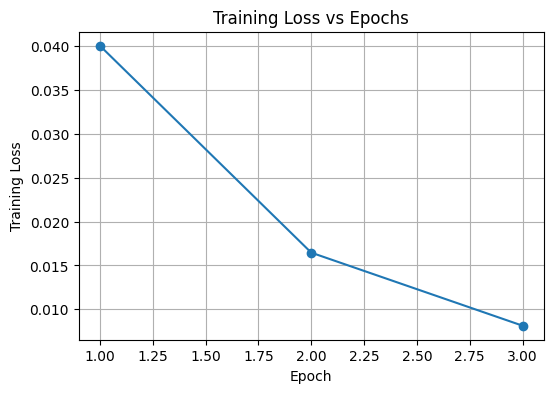

In [7]:
import torch
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

EPOCHS = 3
LEARNING_RATE = 5e-6

optimizer = torch.optim.AdamW(list(question_encoder.parameters()) + list(context_encoder.parameters()),
                              lr=LEARNING_RATE)

scaler = GradScaler(enabled=torch.cuda.is_available())
epoch_losses = []

question_encoder.train()
context_encoder.train()

for epoch in range(EPOCHS):
    total_loss = 0.0

    for q_enc, ctx_enc in train_loader:
        optimizer.zero_grad()

        # -------Move batch to GPU
        q_enc   = {k: v.to(DEVICE, non_blocking=True) for k,v in q_enc.items()}
        ctx_enc = {k: v.to(DEVICE, non_blocking=True) for k,v in ctx_enc.items()}

        B = q_enc["input_ids"].size(0)

        # -------Forward pass with mixed precision
        with autocast(enabled=torch.cuda.is_available()):
            q_out   = question_encoder(**q_enc).pooler_output  # [B, H]
            ctx_out = context_encoder(**ctx_enc).pooler_output  # [2B, H]
            p_out, n_out = ctx_out.split(B, dim=0)

            # -------Cosine margin loss
            pos = torch.cosine_similarity(q_out, p_out, dim=1)
            neg = torch.cosine_similarity(q_out, n_out, dim=1)
            loss = (0.2 - pos + neg).clamp_min_(0).mean()

        # -------Backward + optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {avg_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

Model saving

In [8]:
question_encoder.save_pretrained("./dpr_question_encoder")
context_encoder.save_pretrained("./dpr_context_encoder")
question_tokenizer.save_pretrained("./dpr_question_encoder")
context_tokenizer.save_pretrained("./dpr_context_encoder")

print("Training complete and models saved!")

Training complete and models saved!


Collect all passages for FAISS

In [9]:
import pandas as pd

# -------Load collection
collection = pd.read_csv("common_dataset_80k.tsv", sep="\t", names=["pid", "text"], dtype={"pid": str, "text": str})

embedding_filename = f"passage_embeddings_{int(collection.shape[0]/1000)}k.npy"

print(len(collection), embedding_filename)  # -------smaller than full 8.8M

80000 passage_embeddings_80k.npy


In [27]:
import torch
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

context_encoder.eval()
context_encoder.to(DEVICE)

# ----------------------------------------------
# Multi-process pre-tokenization with HuggingFace Datasets
# ----------------------------------------------
# Create a HF Dataset containing only the passage text column
raw_ds = Dataset.from_pandas(collection[["text"]])

# Tokenization function (returns dict of model inputs)
def tok(batch):
    return context_tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",   # fixed length => tensorize easily
        max_length=256,
    )

# Map with multiprocessing (adjust num_proc to available CPU cores)
# remove original text column to save memory
print("Tokenizing passages (multi-process)...")
tok_ds = raw_ds.map(
    tok,
    batched=True,
    batch_size=512,
    num_proc=4,          # change if you have fewer cores
    remove_columns=["text"],
    desc="Tokenizing"
)

# Set PyTorch format for direct tensor access
Tok_COLUMNS = [c for c in ["input_ids", "attention_mask", "token_type_ids"] if c in tok_ds.column_names]
tok_ds.set_format(type="torch", columns=Tok_COLUMNS)

# DataLoader to stream batches to the encoder (no need for workers now; already tokenized)
EMB_BATCH_SIZE = 64  # tune based on GPU memory
passage_loader = DataLoader(tok_ds, batch_size=EMB_BATCH_SIZE, shuffle=False)

passage_embeddings = []
print("Encoding passages...")
with torch.no_grad():
    for batch in tqdm(passage_loader, desc="Encoding"):
        batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        emb = context_encoder(**batch).pooler_output  # [B, H]
        passage_embeddings.append(emb.cpu())

# Concatenate all batches
passage_embeddings = torch.cat(passage_embeddings, dim=0).numpy()
print("Passage embeddings shape:", passage_embeddings.shape)

# Save
np.save(embedding_filename, passage_embeddings)

Tokenizing passages (multi-process)...


Tokenizing (num_proc=4): 100%|██████████| 80000/80000 [00:44<00:00, 1791.93 examples/s]


Encoding passages...


Encoding: 100%|██████████| 1250/1250 [20:53<00:00,  1.00s/it]


Passage embeddings shape: (80000, 768)


Save embeddings

In [10]:
import numpy as np

# Load later
passage_embeddings = np.load(embedding_filename)
print(passage_embeddings.shape)

(80000, 768)


Build FAISS Index

In [11]:
import faiss
dim = passage_embeddings.shape[1]  # typically 768 for DPR
faiss.normalize_L2(passage_embeddings)  # normalize for cosine similarity
index = faiss.IndexFlatIP(dim)
index.add(passage_embeddings)

print("Number of vectors in FAISS:", index.ntotal)

Number of vectors in FAISS: 80000


METRICS

In [12]:
import numpy as np
import torch
import faiss
from tqdm import tqdm
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import pandas as pd
from eval_metrics import average_precision_at_k, ndcg_at_k, recall_at_k

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ----------------------------
# Load DPR + FAISS + collection
# ----------------------------
question_encoder = DPRQuestionEncoder.from_pretrained("./dpr_question_encoder").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("./dpr_question_encoder")

# NOTE: passage_embeddings rows must align with collection rows (same order)
index = faiss.IndexFlatIP(passage_embeddings.shape[1])
index.add(passage_embeddings)

collection["pid"] = collection["pid"].astype(str)
pids_list = collection["pid"].tolist()
retrieval_file = "dpr_results.tsv"

def evaluate(queries_df: pd.DataFrame,
             qrels_df: pd.DataFrame,
             top_k=10,
             recall_k=100,
             store_k: int = 50):
    """
    Evaluate retrieval metrics + save the top-k retrieved docs.

    Parameters
    ----------
    queries_df : DataFrame with columns ['qid','query'] (str)
    qrels_df   : DataFrame with columns ['qid','pid','rel'] (str, str, int)
    top_k      : K for MAP@K / nDCG@K
    recall_k   : K for Recall@K
    store_k    : number of candidates per query to store
    """
    rel_set_by_qid = qrels_df.groupby("qid")["pid"].apply(set).to_dict()
    # Keep a dict form for nDCG function (relevance always = 1)
    rel_dict_by_qid = {qid: {pid: 1 for pid in pid_set}
                       for qid, pid_set in rel_set_by_qid.items()}

    # Map qid -> query text
    qid2query = dict(zip(queries_df["qid"], queries_df["query"]))
    qids = list(qid2query.keys())
    queries_list = [qid2query[q] for q in qids]

    ap_scores, ndcg_scores, recall_scores = [], [], []

    retrieval_rows = []

    for qid, q in tqdm(zip(qids, queries_list), total=len(queries_list), desc="Evaluating"):
        enc = question_tokenizer(
            [q],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to(DEVICE)

        with torch.no_grad():
            q_emb = question_encoder(**enc).pooler_output  # [1, dim]
            q_emb = torch.nn.functional.normalize(q_emb, p=2, dim=1)

        D, I = index.search(q_emb.detach().cpu().numpy(), store_k)  # [1, K]

        ranked_pids_for_metrics = [pids_list[idx] for idx in I[0][:store_k]]

        rel_dict = rel_dict_by_qid.get(qid, {})
        rel_set = rel_set_by_qid.get(qid, set())

        # Metrics (MAP@k, nDCG@k, Recall@recall_k)
        ap_scores.append(average_precision_at_k(ranked_pids_for_metrics, rel_set, k=top_k))
        ndcg_scores.append(ndcg_at_k(ranked_pids_for_metrics, rel_dict, k=top_k))
        recall_scores.append(recall_at_k(ranked_pids_for_metrics, rel_set, k=recall_k))

        # Store retrieval candidates for re-ranking
        store_scores = D[0][:store_k]
        for rank, (pid, score) in enumerate(zip(ranked_pids_for_metrics, store_scores), start=1):
            row = {
                "qid": qid,
                "retrieved_pid": pid,
                "rank": rank,
                "vector_score": float(score)
            }
            retrieval_rows.append(row)

    metrics = {
        f"MAP@{top_k}": float(np.mean(ap_scores)) if ap_scores else 0.0,
        f"nDCG@{top_k}": float(np.mean(ndcg_scores)) if ndcg_scores else 0.0,
        f"Recall@{recall_k}": float(np.mean(recall_scores)) if recall_scores else 0.0,
        "num_queries": len(queries_list)
    }

    if retrieval_rows is not None:
        retrieval_df = pd.DataFrame(retrieval_rows)
        retrieval_df.to_csv(retrieval_file, sep="\t", index=False)

    return metrics


qrels_for_eval = pd.read_csv("qrels_for_eval.tsv", sep="\t", dtype=str)

sampled_queries = pd.read_csv(f"sampled_queries_1k.tsv", sep="\t", dtype=str)
sampled_queries

,qid,query
0,524318,treating diabetes
1,524341,treatment and prognosis for lung cancer
2,524447,treatment of varicose veins in legs
3,524569,trend what does it means
4,362,. what are the president's main duties? explai...
...,...,...
995,576078,what are traditional new year's eve meals
996,523224,toxic lithium effects
997,523248,toxoplasmosis symptoms
998,523645,transaction finance definition


In [13]:
# Run evaluation + save top-k (for re-ranking)
# This will store top 50 candidates per query (adjust as needed)
metrics = evaluate(
    sampled_queries,
    qrels_for_eval,
    top_k=10,
    recall_k=10,
    store_k=10,
)
print(metrics)

Evaluating: 100%|██████████| 1000/1000 [00:30<00:00, 32.54it/s]


{'MAP@10': 0.45784955687830686, 'nDCG@10': 0.5472509816291554, 'Recall@10': 0.62025, 'num_queries': 1000}


In [33]:
retrieval_file_df = pd.read_csv(retrieval_file, sep="\t")
retrieval_file_df

,qid,retrieved_pid,rank,vector_score
0,524318,7084803,1,0.584637
1,524318,611973,2,0.558240
2,524318,227741,3,0.528598
3,524318,277224,4,0.518070
4,524318,7723307,5,0.516847
...,...,...,...,...
9995,523851,4079216,6,0.460303
9996,523851,797453,7,0.437810
9997,523851,7698090,8,0.432762
9998,523851,782017,9,0.418608
